# This notebook retrieves raw data from three relevant tables and combines the features we care about into one dataframe. We save the processed data because merging all the data is costly, and because we will use it in other notebooks.


**Description of columns**


- **user_id**: Unique identifier for the user (from triplets table).
- **song_id**: Echo Nest song ID. Multiple tracks can share the same song_id if they are different versions of the same song. However, we removed these duplicates from the track_metadata table.
- **plays**: Number of times the user played the song (from triplets table).
- **track_id**: The Echo Nest ID of this particular track on which the analysis was done. Unique identifier for each track within the Million Song Dataset.
- **title**: Title of the song.
- **release**: Release (album name) from which the track was taken.
- **artist_id**: Unique identifier for the artist. Matches the artist_id field in the track_metadata table and artist_term table.
- **artist_mbid**: MusicBrainz ID (MBID) for the artist.
- **artist_name**: Name of the artist.
- **duration**: Duration of the track in seconds.
- **artist_familiarity**: EchoNest numerical estimation of how familiar a song’s artist currently is to the world.
- **artist_hotttnesss**: EchoNest numerical estimation of how hottt a song’s artist currently is.
- **year**: The year the track was released according to MusicBrainz.
- **track_7digitalid**: Identifier linking the song to the 7digital online music catalog.
- **shs_perf**: Performance number on the SecondHandSongs website. Default value is -1.
- **shs_work**: Clique numbers from the SecondHandSongs train and test files. If the work is known by MillionSongs, then the number is positive.
- **majority_genre**: The most common or dominant genre associated with the artist or track (derived field).
- **minority_genre**: A secondary or less frequent genre associated with the artist or track (derived field).


## Retrieve Raw Data

In [1]:
import sqlite3

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
# If using a local environment
data_path = "data/"

In [3]:
# # If using a collab environment
# from google.colab import drive
#
# drive.mount('/content/drive')
#
# data_path = "/content/drive/MyDrive/DSE/DSE 220 Final Project/Data/"

In [4]:
# Where the raw data is located
user_song_play_path = data_path + "train_triplets.txt"
track_metadata_path = data_path + "track_metadata.db"
genre_labels_path = data_path + "msd_tagtraum_cd2.cls"
# Where the processed dataframes will be saved
users_cleaned_df_path = data_path + "users_cleaned_df.parquet"
songs_df_cleaned_path = data_path + "songs_df_cleaned.parquet"

In [5]:
# Songs can have multiple track ids, so we retrieve only one
# Once we have only one song, we are no longer concerned with "tracks"
track_metadata_conn = sqlite3.connect(track_metadata_path)
track_metadata_sql_query = "SELECT * FROM songs"
song_metadata_df = pd.read_sql_query(
    track_metadata_sql_query,
    track_metadata_conn
).drop_duplicates(subset=['song_id'])
track_metadata_conn.close()

user_song_play_df = pd.read_csv(
    user_song_play_path,
    sep='\t',
    names=['user_id', 'song_id', 'plays'],
)

genre_labels_df = pd.read_csv(
    genre_labels_path,
    sep='\t',
    names=['track_id', 'majority_genre', 'minority_genre'],
    skiprows=7
)

## Aggregate and Clean Data

In [6]:
# Add genre labels to the songs
song_metadata_with_genre_df = pd.merge(
    song_metadata_df,
    genre_labels_df,
    on='track_id',
    how='left'  # so we can keep all rows
)

In [7]:
# We drop redundant artist id columns and the shs columns
songs_cols_to_keep = ['song_id', 'track_id', 'title', 'release', 'duration',
                      'artist_id', 'artist_name',
                      'artist_familiarity', 'artist_hotttnesss', 'year', 'majority_genre', 'minority_genre']
song_metadata_with_genre_df = song_metadata_with_genre_df[songs_cols_to_keep]

In [8]:
song_metadata_with_genre_df.head()

song_id            track_id              title  \
0  SOQMMHC12AB0180CB8  TRMMMYQ128F932D901       Silent Night   
1  SOVFVAK12A8C1350D9  TRMMMKD128F425225D        Tanssi vaan   
2  SOGTUKN12AB017F4F1  TRMMMRX128F93187D9  No One Could Ever   
3  SOBNYVR12A8C13558C  TRMMMCH128F425532C      Si Vos Querés   
4  SOHSBXH12A8C13B0DF  TRMMMWA128F426B589   Tangle Of Aspens   

                                release   duration           artist_id  \
0                 Monster Ballads X-Mas  252.05506  ARYZTJS1187B98C555   
1                           Karkuteillä  156.55138  ARMVN3U1187FB3A1EB   
2                                Butter  138.97098  ARGEKB01187FB50750   
3                               De Culo  145.05751  ARNWYLR1187B9B2F9C   
4  Rene Ablaze Presents Winter Sessions  514.29832  AREQDTE1269FB37231   

        artist_name  artist_familiarity  artist_hotttnesss  year  \
0  Faster Pussy cat            0.649822           0.394032  2003   
1  Karkkiautomaatti            0.439604           0.356992  1995   
2    Hudson Mohawke            0.643681           0.437504  2006   
3       Yerba Brava            0.448501           0.372349  2003   
4        Der Mystic            0.000000           0.000000     0   

  majority_genre minority_genre  
0            NaN            NaN  
1            NaN            NaN  
2     Electronic            Rap  
3            NaN            NaN  
4            NaN            NaN

In [9]:
song_metadata_with_genre_df['year'].value_counts().head()

year
0       484284
2007     39340
2006     37486
2005     34872
2008     34684
Name: count, dtype: int64

In [10]:
# Data cleaning:

# Drop songs with no genre labels as genres play an important role in clustering
# the users based on similar tastes
song_metadata_with_genre_df_clean = song_metadata_with_genre_df.dropna(subset=['majority_genre'])

# Drop songs with year=0 i.e., no year value available
# We use the year to group users who listen to music from similar periods
song_metadata_with_genre_df_clean = song_metadata_with_genre_df_clean[song_metadata_with_genre_df_clean['year'] != 0]

### EDA on features

In [11]:
song_metadata_with_genre_df_clean['year'].value_counts().head()

year
2007    17538
2006    16646
2005    15620
2008    13968
2004    13031
Name: count, dtype: int64

In [12]:
song_metadata_with_genre_df_clean.describe(include='number')

duration  artist_familiarity  artist_hotttnesss           year
count  222919.000000       222919.000000      222919.000000  222919.000000
mean      251.862589            0.636693           0.444543    1998.176140
std       110.335887            0.113975           0.097839      10.939399
min         0.600360            0.000000           0.000000    1922.000000
25%       189.988120            0.565935           0.386480    1994.000000
50%       234.579140            0.632131           0.434256    2002.000000
75%       289.932610            0.710901           0.498842    2006.000000
max      2999.509750            1.000000           1.082503    2010.000000

In [13]:
song_metadata_with_genre_df_clean.describe(include='object')

song_id            track_id   title        release  \
count               222919              222919  222919         222919   
unique              222919              222919  173050          55865   
top     SOGTUKN12AB017F4F1  TRMMMRX128F93187D9   Intro  Greatest Hits   
freq                     1                   1     285            725   

                 artist_id        artist_name majority_genre minority_genre  
count               222919             222919         222919          70319  
unique               20789              22851             15             15  
top     AR91C8S1187B990901  Bruce Springsteen           Rock           Rock  
freq                   140                127          93507          15877

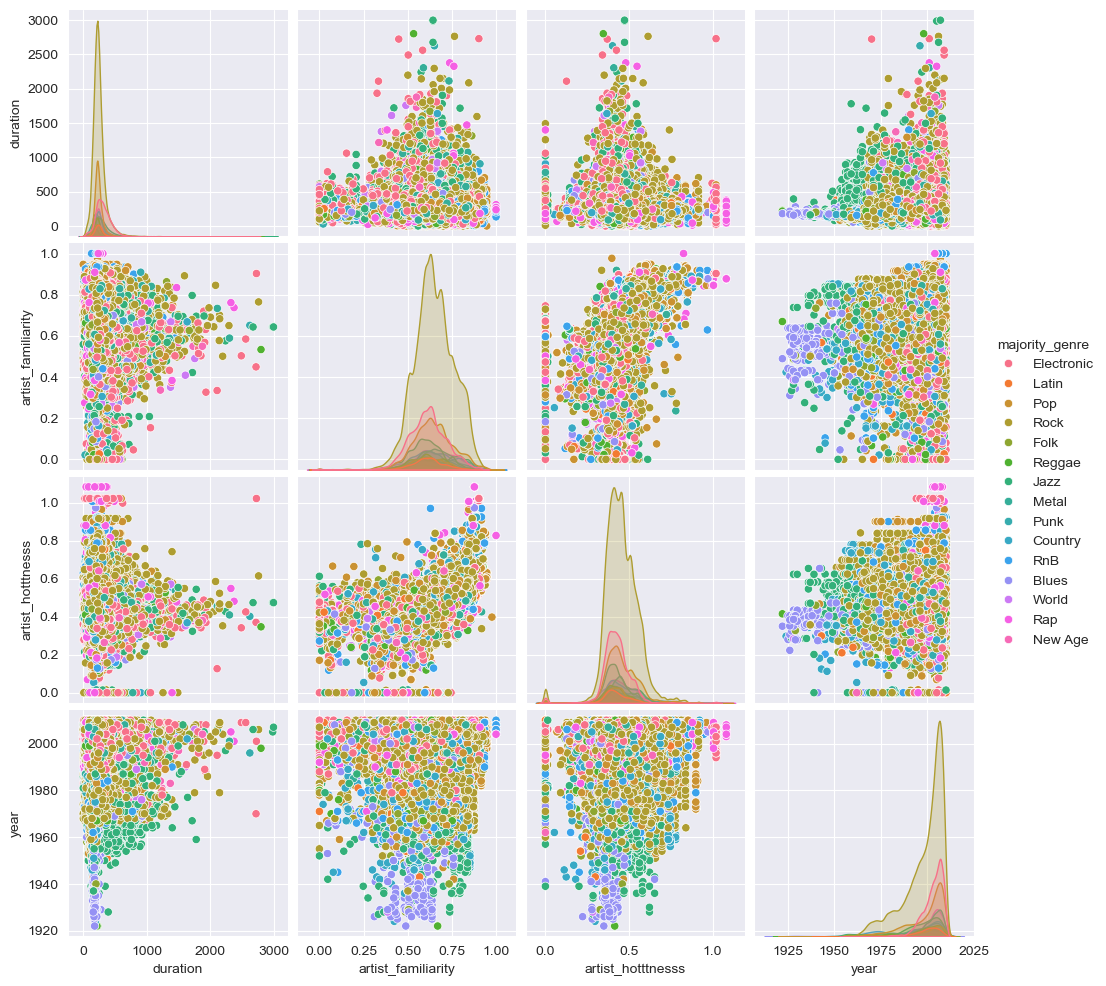

In [14]:
# Visualize and inspect the distribution of songs across different variables
sns.pairplot(song_metadata_with_genre_df_clean, hue='majority_genre')
plt.show()

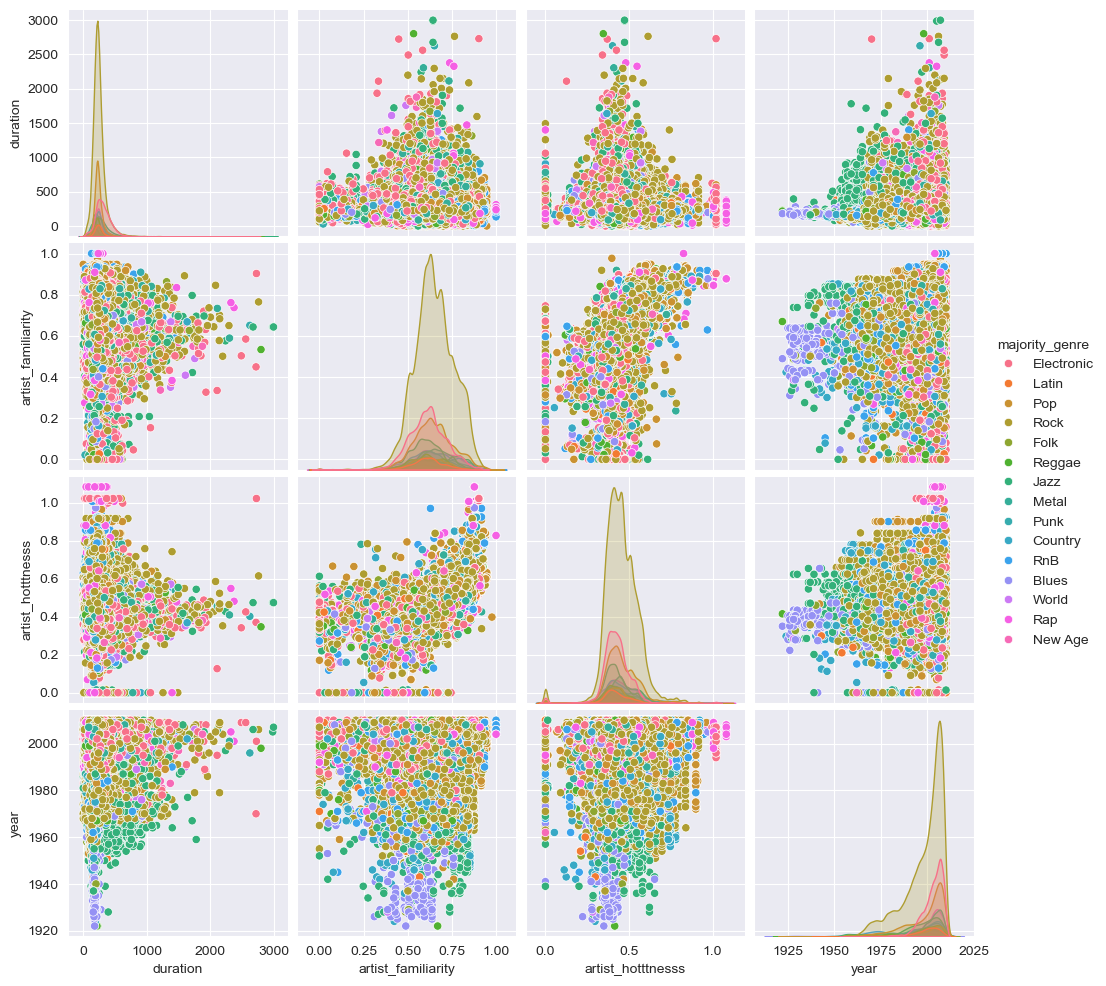

In [15]:
# Visualize and inspect the distribution of songs across different variables
# Colored by majority genre because we think that is going to be a significant
# feature
sns.pairplot(song_metadata_with_genre_df_clean, hue='majority_genre')
plt.show()

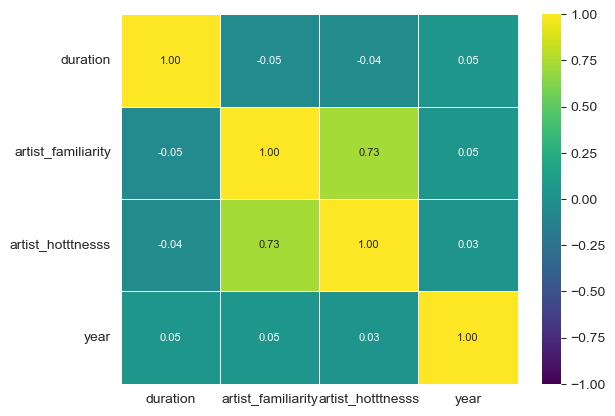

In [16]:
# Visualize and inspect correlation different features for songs
sns.heatmap(
    song_metadata_with_genre_df_clean.select_dtypes(include='number').corr(),
    annot=True,
    cmap='viridis',
    fmt='.2f',
    linewidths=.5,
    annot_kws={"size": 8},
    vmin=-1,
    vmax=1
)
plt.show()

In [17]:
# Add song meta-data to the user_song interactions dataframe
songs_df_full = pd.merge(user_song_play_df, song_metadata_with_genre_df_clean, on='song_id')
# Calculate the amount of time a user spent listening to a particular song
songs_df_full['tot_track_time'] = songs_df_full['duration'] * songs_df_full['plays']
songs_df = songs_df_full.copy()

In [18]:
songs_df.columns

Index(['user_id', 'song_id', 'plays', 'track_id', 'title', 'release',
       'duration', 'artist_id', 'artist_name', 'artist_familiarity',
       'artist_hotttnesss', 'year', 'majority_genre', 'minority_genre',
       'tot_track_time'],
      dtype='object')

In [19]:
songs_df.describe(include='number')

plays      duration  artist_familiarity  artist_hotttnesss  \
count  2.610271e+07  2.610271e+07        2.610271e+07       2.610271e+07   
mean   2.751063e+00  2.473164e+02        7.496611e-01       5.602048e-01   
std    6.314971e+00  8.813194e+01        1.074408e-01       1.322835e-01   
min    1.000000e+00  7.832200e-01        0.000000e+00       0.000000e+00   
25%    1.000000e+00  2.001236e+02        6.806601e-01       4.744282e-01   
50%    1.000000e+00  2.348926e+02        7.648824e-01       5.411549e-01   
75%    2.000000e+00  2.773938e+02        8.347145e-01       6.051912e-01   
max    9.667000e+03  2.999510e+03        1.000000e+00       1.082503e+00   

               year  tot_track_time  
count  2.610271e+07    2.610271e+07  
mean   2.000681e+03    6.817397e+02  
std    9.339874e+00    1.630573e+03  
min    1.922000e+03    7.832200e-01  
25%    1.997000e+03    2.224322e+02  
50%    2.004000e+03    2.966461e+02  
75%    2.007000e+03    6.094885e+02  
max    2.010000e+03    1.948484e+06

### Create final dataframe by pulling relevant features

In [20]:
# Generate features per user for clustering
user_total_plays = songs_df.groupby('user_id', as_index=False)['plays'].sum().rename(
    columns={'plays': 'total_play_count'})

user_unique_songs = songs_df.groupby('user_id', as_index=False)['song_id'].count().rename(
    columns={'song_id': 'unqiue_song_count'})
user_unique_artists = songs_df.groupby('user_id', as_index=False)['artist_id'].count().rename(
    columns={'artist_id': 'unqiue_artist_count'})
user_total_time = songs_df.groupby('user_id', as_index=False)['tot_track_time'].sum().rename(
    columns={'tot_track_time': 'total_play_time'})

user_fav_artist = songs_df.groupby('user_id', as_index=False)['artist_id'].value_counts()
user_fav_artist = user_fav_artist.loc[user_fav_artist.groupby('user_id')['count'].idxmax()].rename(
    columns={'artist_id': 'fav_artist', "count": "fav_artist_plays"})

user_fav_maj_genre = songs_df.groupby('user_id', as_index=False)['majority_genre'].value_counts()
user_fav_maj_genre = user_fav_maj_genre.loc[user_fav_maj_genre.groupby('user_id')['count'].idxmax()].rename(
    columns={'majority_genre': 'fav_maj_genre', "count": "fav_maj_count"})
user_fav_min_genre = songs_df.groupby('user_id', as_index=False)['minority_genre'].value_counts()
user_fav_min_genre = user_fav_min_genre.loc[user_fav_min_genre.groupby('user_id')['count'].idxmax()].rename(
    columns={'minority_genre': 'fav_min_genre', "count": "fav_min_count"})

user_fav_year = songs_df.groupby('user_id', as_index=False)['year'].value_counts()
user_fav_year = user_fav_year[user_fav_year['year'] != 0]
user_fav_year = user_fav_year.loc[user_fav_year.groupby('user_id')['count'].idxmax()].rename(
    columns={'year': 'fav_year', "count": "year_count"})

user_fav_song = songs_df.loc[songs_df.groupby('user_id')['plays'].idxmax()]
user_fav_song = user_fav_song[['user_id', 'song_id', 'plays', 'duration', 'tot_track_time']].rename(
    columns={'song_id': 'fav_song', "plays": "fav_song_plays", 'duration': 'fav_song_duration',
             'tot_track_time': 'tot_fav_song_play_time'})

In [21]:
# Create users dataframe using the features created above
users_df = pd.merge(user_total_plays, user_total_time, on="user_id")
users_df = pd.merge(users_df, user_unique_artists, on="user_id")
users_df = pd.merge(users_df, user_unique_songs, on="user_id")
users_df = pd.merge(users_df, user_fav_maj_genre, on="user_id")
users_df = pd.merge(users_df, user_fav_min_genre, on="user_id")
users_df = pd.merge(users_df, user_fav_year, on="user_id")
users_df = pd.merge(users_df, user_fav_artist, on="user_id")
users_df = pd.merge(users_df, user_fav_song, on="user_id")

### EDA on final dataframe

In [22]:
users_df.describe(include='object')

user_id fav_maj_genre fav_min_genre  \
count                                     933431        933431        933431   
unique                                    933431            15            15   
top     00000b722001882066dff9d2da8a775658053ea0          Rock          Rock   
freq                                           1        608500        213901   

                fav_artist            fav_song  
count               933431              933431  
unique               10242               72068  
top     ARJ7KF01187B98D717  SOAUWYT12A81C206F1  
freq                 16350               21161

In [23]:
users_df.describe(include='number')

total_play_count  total_play_time  unqiue_artist_count  \
count     933431.000000     9.334310e+05        933431.000000   
mean          75.072520     1.860510e+04            27.352648   
std          106.195572     2.630841e+04            35.009184   
min            1.000000     5.289751e+01             1.000000   
25%           17.000000     4.263698e+03             9.000000   
50%           39.000000     9.661946e+03            15.000000   
75%           90.000000     2.224083e+04            32.000000   
max        11697.000000     2.408770e+06          2365.000000   

       unqiue_song_count  fav_maj_count  fav_min_count       fav_year  \
count      933431.000000  933431.000000  933431.000000  933431.000000   
mean           27.352648      15.393956       3.465819    2001.049530   
std            35.009184      21.173470       4.441338      10.043838   
min             1.000000       1.000000       1.000000    1924.000000   
25%             9.000000       4.000000       1.000000    1999.000000   
50%            15.000000       8.000000       2.000000    2005.000000   
75%            32.000000      18.000000       4.000000    2008.000000   
max          2365.000000    1411.000000     216.000000    2010.000000   

          year_count  fav_artist_plays  fav_song_plays  fav_song_duration  \
count  933431.000000     933431.000000   933431.000000      933431.000000   
mean        5.766003          5.351766       12.863076         250.970620   
std         5.842962          5.855139       24.700324          88.089775   
min         1.000000          1.000000        1.000000           1.122810   
25%         2.000000          2.000000        3.000000         202.579140   
50%         4.000000          3.000000        7.000000         237.792200   
75%         7.000000          7.000000       15.000000         280.972610   
max       267.000000         80.000000     9667.000000        2328.110570   

       tot_fav_song_play_time  
count            9.334310e+05  
mean             3.232460e+03  
std              6.284949e+03  
min              1.122810e+00  
25%              7.644455e+02  
50%              1.658510e+03  
75%              3.603012e+03  
max              1.948484e+06

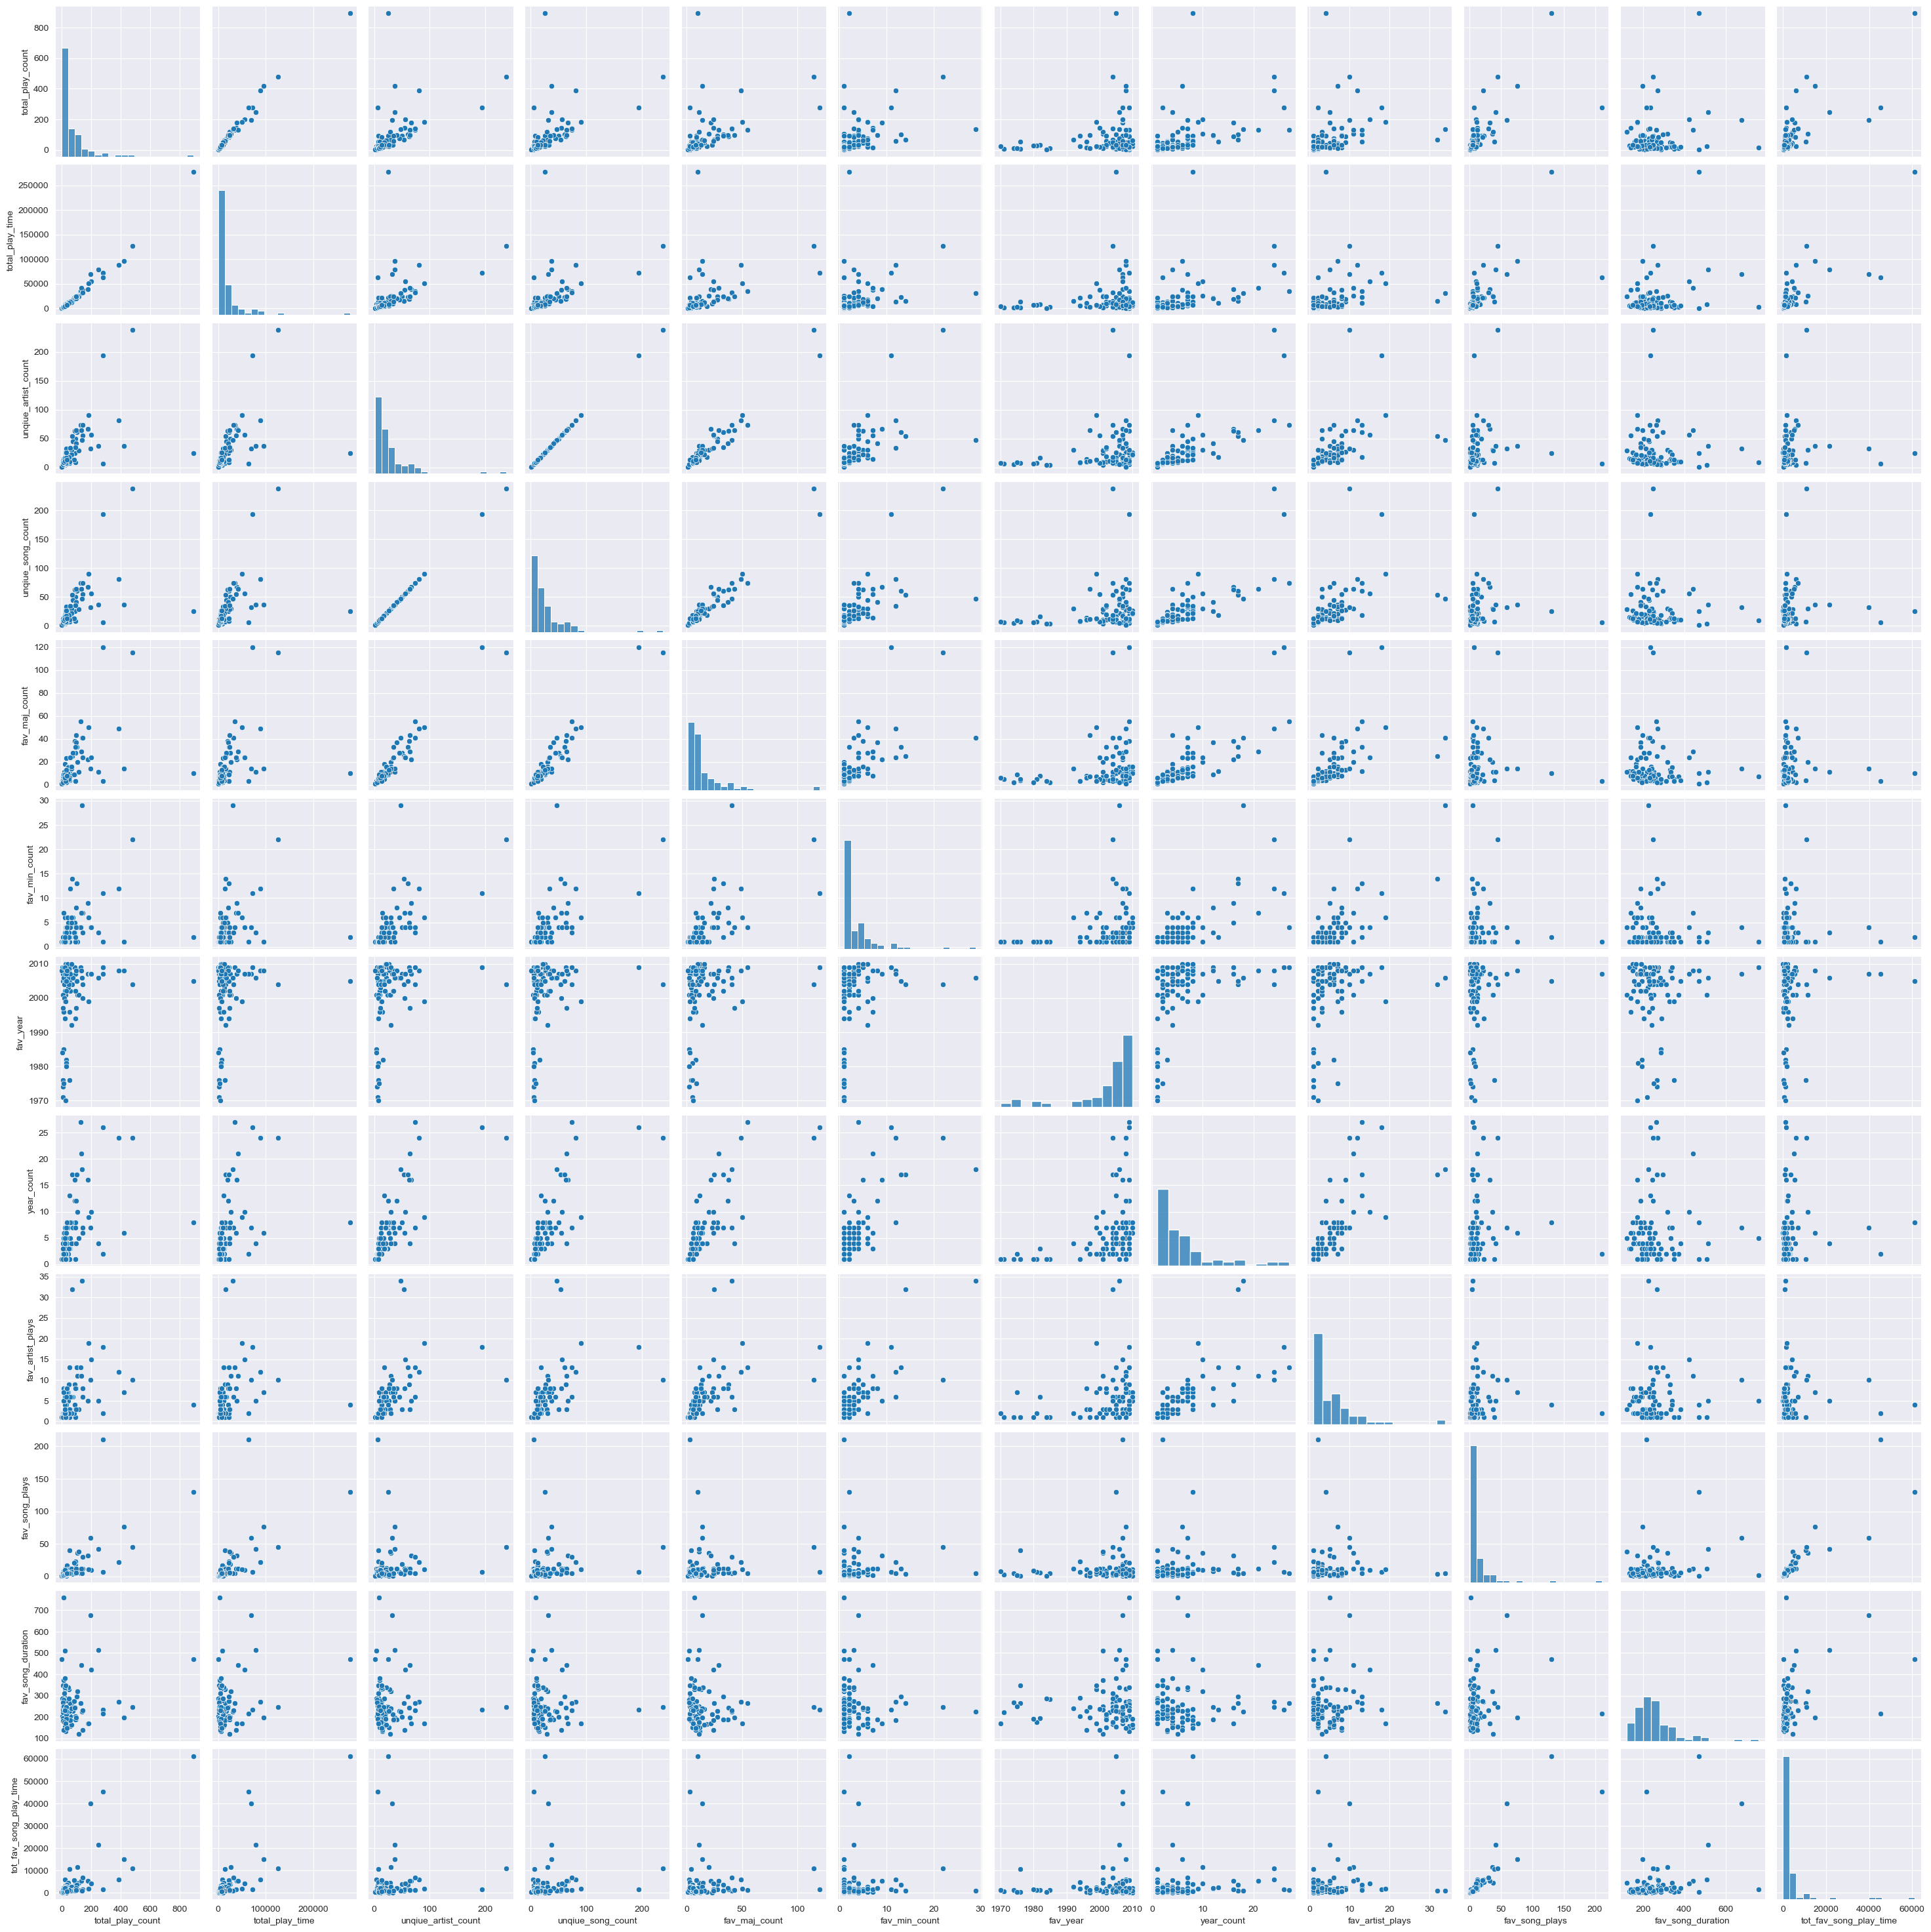

In [24]:
# Visualize and inspect the distribution of users across different features
sns.pairplot(users_df.sample(frac=0.0001))
plt.show()

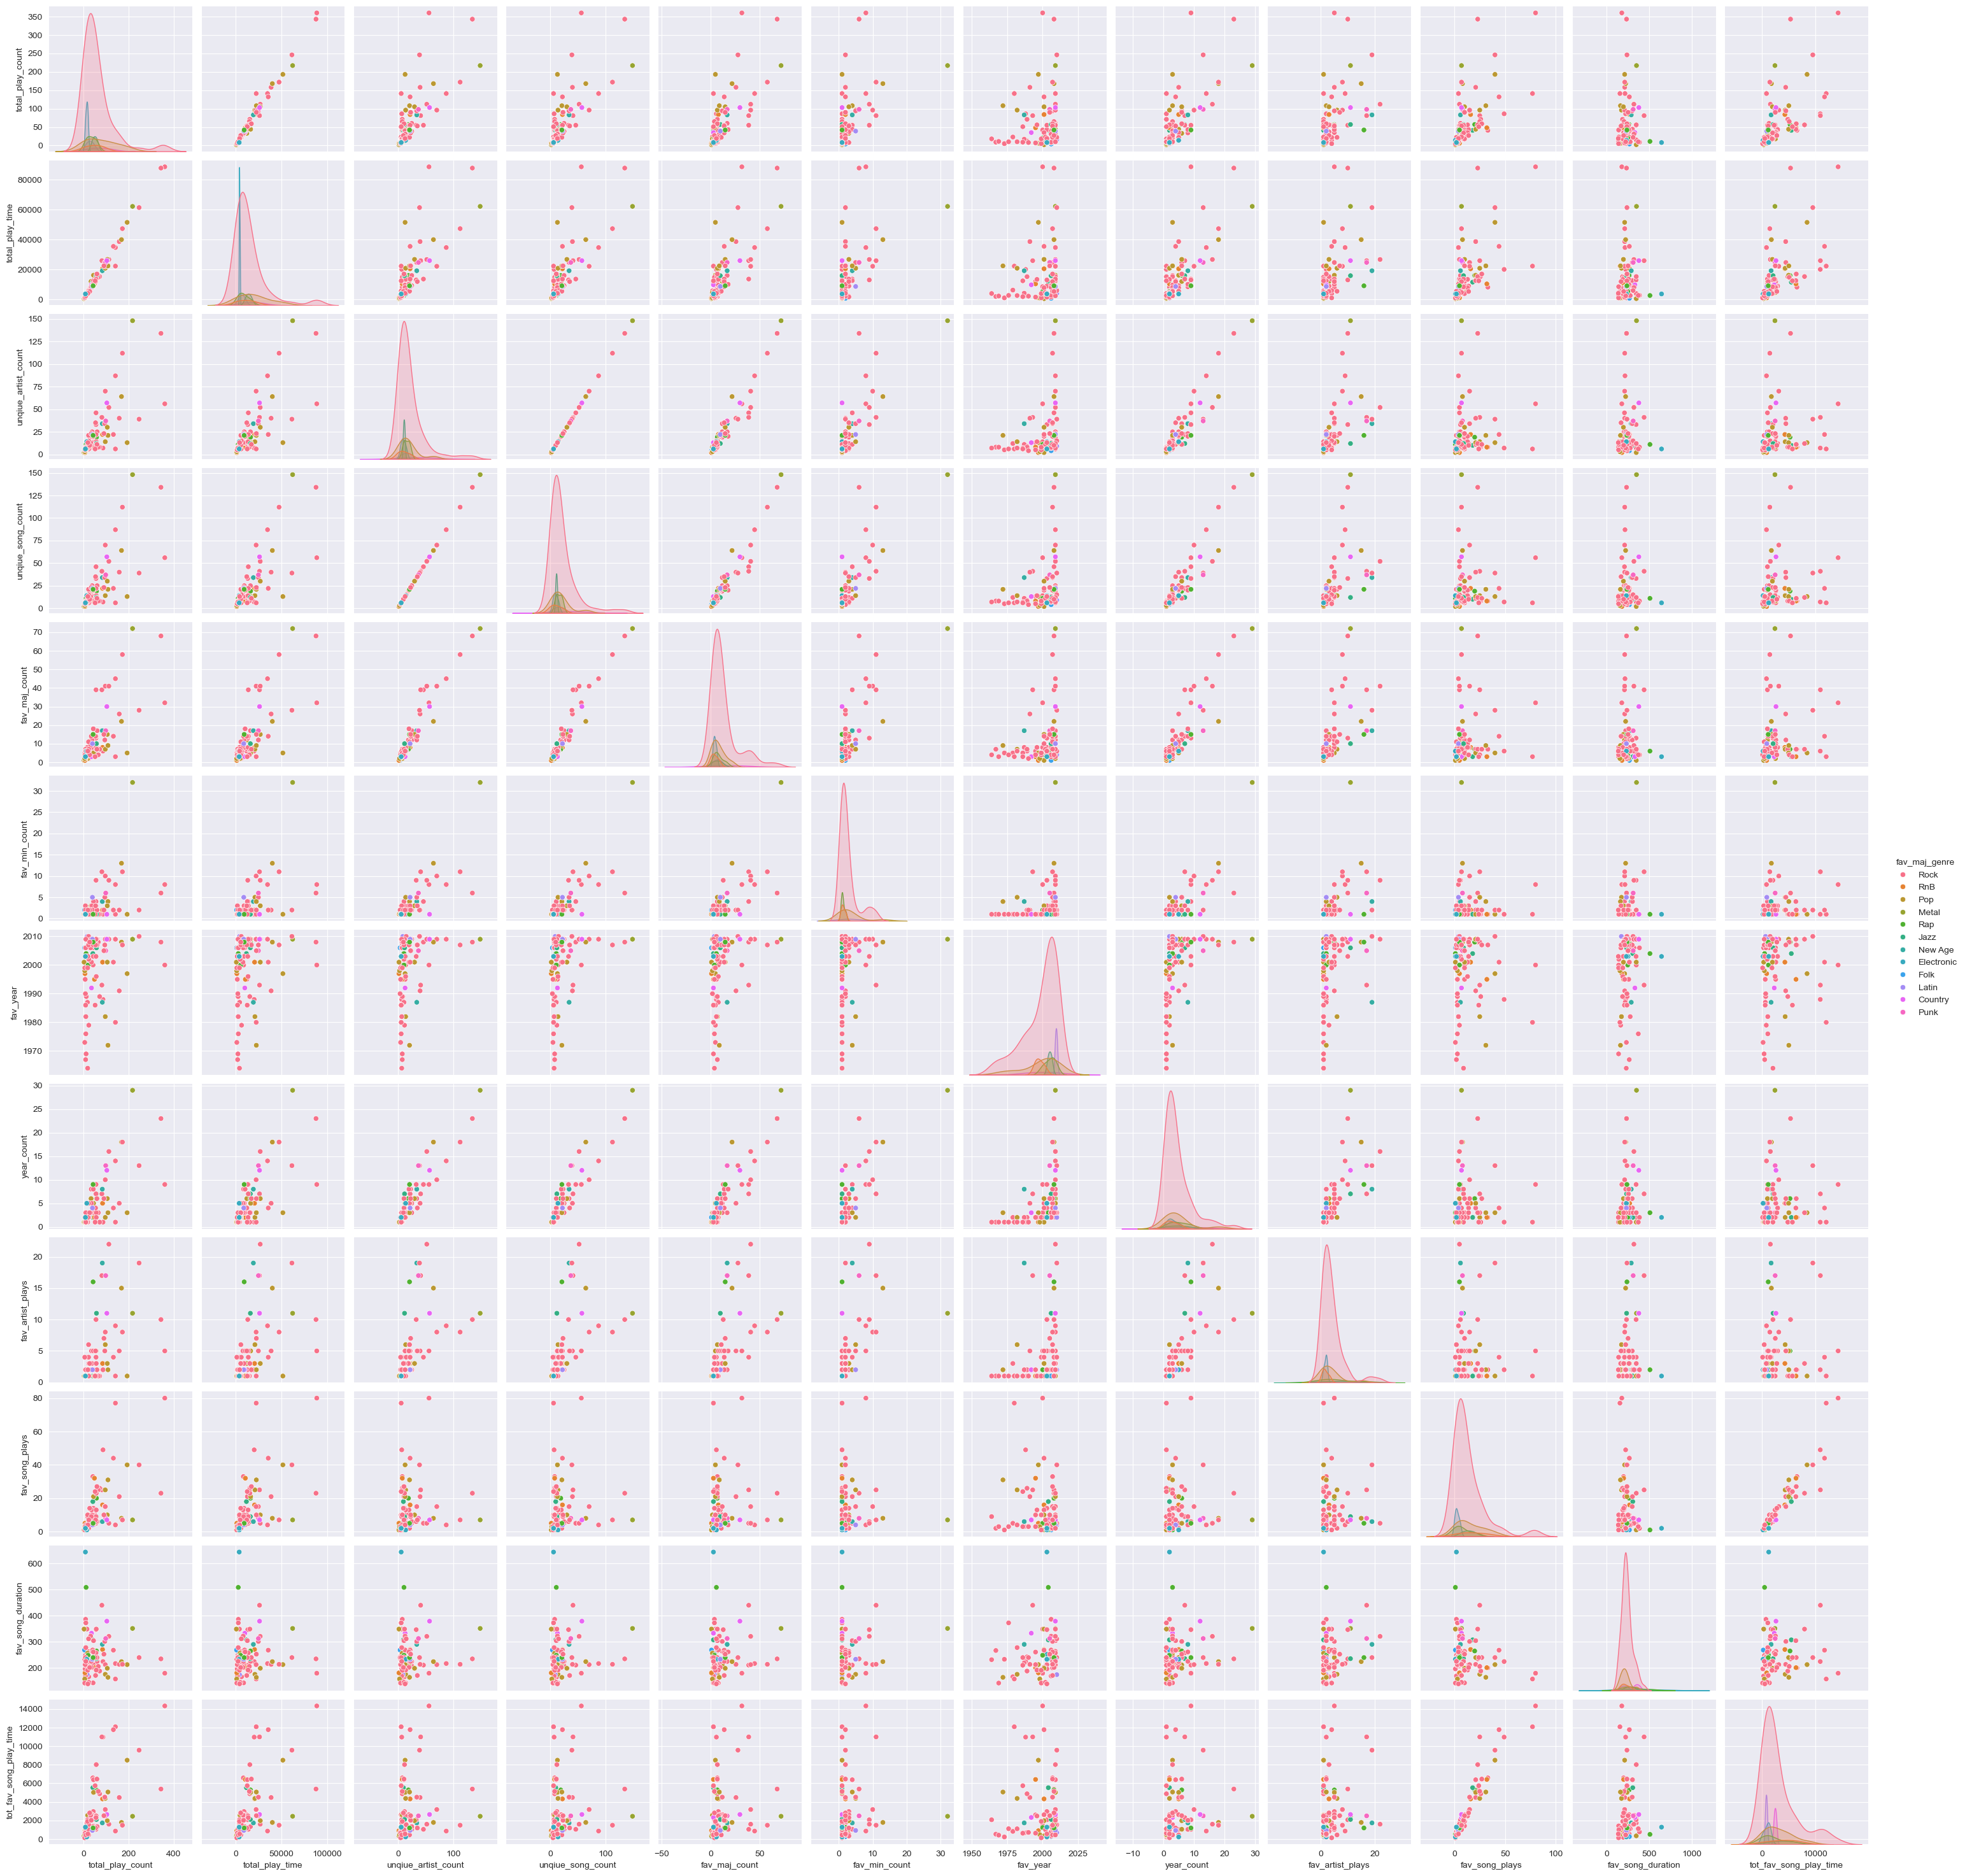

In [25]:
# Visualize and inspect the distribution of users across different features
# Colored by favorite majority genre because we think that is going to be a
# significant feature

sns.pairplot(users_df.sample(frac=0.0001), hue='fav_maj_genre')
plt.show()

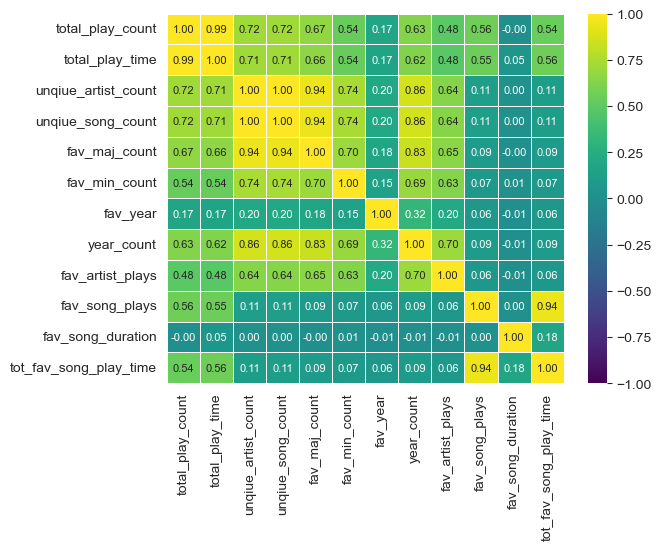

In [26]:
# Visualize and inspect correlation different features for users
sns.heatmap(
    users_df.select_dtypes(include='number').corr(),
    annot=True,
    cmap='viridis',
    fmt='.2f',
    linewidths=.5,
    annot_kws={"size": 8},
    vmin=-1,
    vmax=1
)
plt.show()

## Save processed data frames for other notebooks to use and process further.

In [27]:
users_df.to_parquet(users_cleaned_df_path, index=False, engine='pyarrow')
print(f"Processed DataFrame saved to: {users_cleaned_df_path}")

Processed DataFrame saved to: data/users_cleaned_df.parquet


In [28]:
songs_df.to_parquet(songs_df_cleaned_path, index=False, engine='pyarrow')
print(f"Processed DataFrame saved to: {songs_df_cleaned_path}")

Processed DataFrame saved to: data/songs_df_cleaned.parquet
